In [2]:
import pandas as pd
import  matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder


In [3]:
df = pd.read_csv('/Users/samir/Documents/GitHub/Google-Zero-Day-in-the-Wild-/0day _In the Wild_ - All.csv')
df.head()

,CVE,Vendor,Product,Type,Description,Date Discovered,Date Patched,Advisory,Analysis URL,Root Cause Analysis,Reported By
0,CVE-2024-23296,Apple,iOS,Memory Corruption,Arbitrary kernel r/w in RTKit,NaN,2024-03-06,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
1,CVE-2024-23225,Apple,iOS,Memory Corruption,Out-of-bounds memory access in Kernel,NaN,2024-03-05,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
2,CVE-2024-23222,Apple,WebKit,Memory Corruption,Type confusion,NaN,2024-01-22,https://support.apple.com/en-us/HT214059,NaN,NaN,NaN
3,CVE-2024-0519,Google,Chrome,Memory Corruption,Out-of-bounds memory access,2024-01-11,2024-01-16,https://chromereleases.googleblog.com/2024/01/...,NaN,NaN,NaN
4,CVE-2023-7024,Google,Chrome,Memory Corruption,Heap overflow in WebRTC,2023-12-19,2023-12-20,https://chromereleases.googleblog.com/2023/12/...,NaN,NaN,Clément Lecigne and Vlad Stolyarov of Google's...


In [4]:
missing_values = df.isnull().sum()
missing_values


CVE                      0
Vendor                   0
Product                  0
Type                     4
Description              0
Date Discovered        188
Date Patched             0
Advisory                 0
Analysis URL           139
Root Cause Analysis    245
Reported By             92
dtype: int64

In [5]:
df_cleaned = df.dropna(subset=['Date Discovered'])
df_cleaned.isnull().sum()
df_cleaned['Date Discovered'] = pd.to_datetime(df_cleaned['Date Discovered'], errors='coerce')
df_cleaned['Date Patched'] = pd.to_datetime(df_cleaned['Date Patched'], errors='coerce')
missing_type_rows =df_cleaned[df_cleaned['Type'].isnull()]

df_cleaned['Time to Patch (Days)'] = (df_cleaned['Date Patched'] - df_cleaned['Date Discovered']).dt.days

# Filter out entries where the 'Time to Patch' is negative or null
final_data = df_cleaned[(df_cleaned['Time to Patch (Days)'] >= 0) & (df_cleaned['Time to Patch (Days)'].notnull())]

# Displaying the updated dataframe
final_data[['Vendor', 'Product', 'Type', 'Time to Patch (Days)']]


/var/folders/89/xn87wdfs76x_gc0q1x5jl_4h0000gn/T/ipykernel_5603/1696299723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date Discovered'] = pd.to_datetime(df_cleaned['Date Discovered'], errors='coerce')
/var/folders/89/xn87wdfs76x_gc0q1x5jl_4h0000gn/T/ipykernel_5603/1696299723.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date Patched'] = pd.to_datetime(df_cleaned['Date Patched'], errors='coerce')
/var/folders/89/xn87wdfs76x_gc0q1x5jl_4h0000gn/T/ipykernel_5603/1696299723

,Vendor,Product,Type,Time to Patch (Days)
3,Google,Chrome,Memory Corruption,5.0
4,Google,Chrome,Memory Corruption,1.0
10,Google,Chrome,Memory Corruption,4.0
16,Google,Chrome,Memory Corruption,2.0
17,Apple,iOS,Memory Corruption,9.0
...,...,...,...,...
293,Microsoft,Windows Kernel,Logic/Design Flaw,24.0
294,Adobe,Flash,Memory Corruption,1.0
297,Adobe,Flash,Use-after-free,22.0
298,Adobe,Flash,Use-after-free,7.0


Linear Regression model to predict Patch Times(Days).

In [6]:
features = final_data[['Vendor', 'Product', 'Type']]
target = final_data['Time to Patch (Days)']
# Encoding categorical features into numerical values
label_encoders = {}
for column in features.columns:
    label_encoders[column] = LabelEncoder()
    features[column] = label_encoders[column].fit_transform(features[column])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train.head(), y_train.head()
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)


Mean Absolute Error: 31.960535042332364
Root Mean Squared Error: 35.74237003665914


/var/folders/89/xn87wdfs76x_gc0q1x5jl_4h0000gn/T/ipykernel_5603/2876078048.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = label_encoders[column].fit_transform(features[column])
/var/folders/89/xn87wdfs76x_gc0q1x5jl_4h0000gn/T/ipykernel_5603/2876078048.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = label_encoders[column].fit_transform(features[column])
/var/folders/89/xn87wdfs76x_gc0q1x5jl_4h0000gn/T/ipykernel_5603/2876078048.py:7: SettingWithCopyWarning: 
A va

Random Forrest Regression Model.

In [11]:
best_rf_model = RandomForestRegressor(min_samples_leaf=4, min_samples_split=10, max_depth=None, bootstrap=True)
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=4, min_samples_split=10)

In [13]:
y_pred = best_rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (Random Forest):", mae_rf)
print("Root Mean Squared Error (Random Forest):", rmse_rf)


Mean Absolute Error (Random Forest): 16.035266221254684
Root Mean Squared Error (Random Forest): 27.352017640977706


Visualizing Important Feature

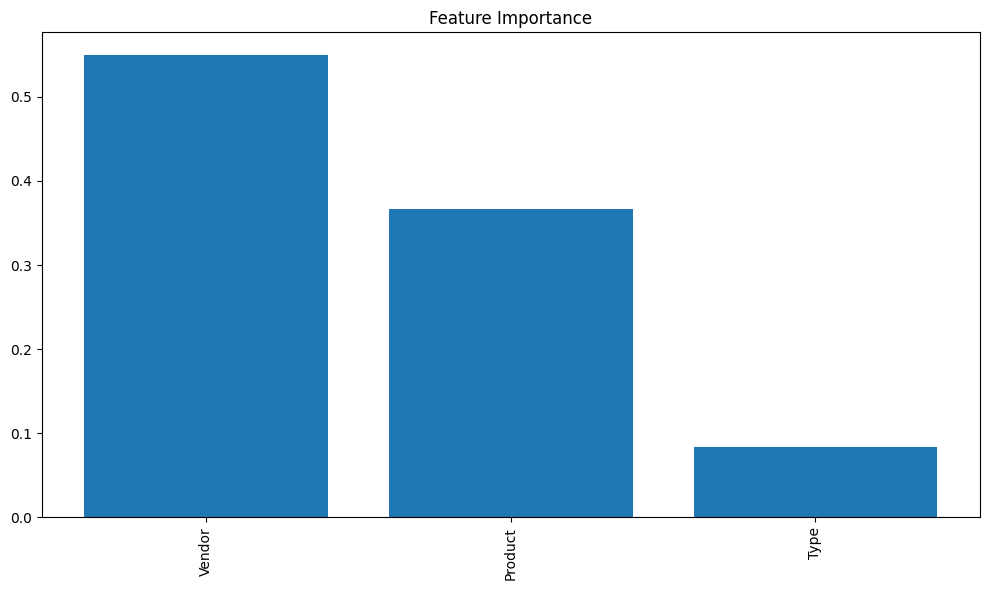

In [14]:
# Get feature importances
feature_importances = best_rf_model.feature_importances_

# Plot feature importances
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

DecisionTree Model.

In [ ]:
dt_model = DecisionTreeRegressor(random_state=42)

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
print("Mean Absolute Error (Decision Tree):", mae_dt)
print("Root Mean Squared Error (Decision Tree):", rmse_dt)


Mean Absolute Error (Decision Tree): 24.191999999999997
Root Mean Squared Error (Decision Tree): 46.913987490110266
